In [1]:
# 结构信息

In [2]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time
from networkx.algorithms.bipartite.basic import color
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号

In [3]:
dof=5  #结构自由度
dt=0.02 #时间步长度
beta=0.25 
gama=0.5
alpha=0.2 #刚度折减系数

In [4]:
#质量矩阵
m=torch.tensor([5000.0,5000.0,5000.0,5000.0,5000.0])  # kg
M=torch.diag(m)

In [5]:
#刚度矩阵
k=torch.tensor([1e6]*5)  #层间刚度 N/m
K0=torch.tensor([
    [k[0]+k[1],-k[1],0,0,0],
    [-k[1],k[1]+k[2],-k[2],0,0],
    [0,-k[2],k[2]+k[3],-k[3],0],
    [0,0,-k[2],k[3]+k[4],-k[4]],
    [0,0,0,-k[4],k[4]]
])

In [6]:
K_re=torch.tensor([
    [-k[0],k[1],0,0,0],
    [0,-k[1],k[2],0,0],
    [0,0,-k[2],k[3],0],
    [0,0,0,-k[3],k[4]],
    [0,0,0,0,-k[4]]])

In [7]:
zeta = 0.05; w1 = 0.03684; w2 = 0.24843  #定义结构阻尼比，1、2阶频率 9层
a_coe = 2*w1*w2*zeta/(w1+w2); b_coe = 2*zeta/(w1+w2)
C =a_coe*M + b_coe*K0  #计算瑞利阻尼

In [8]:
# Newmark_beta法计算系数
a0=1/(beta*dt**2)
a1=1/(beta*dt)
a2=1/(2*beta)-1
a3=gama/(beta*dt)
a4=gama/beta-1
a5=(gama/beta-2)*dt/2

In [9]:
L=torch.zeros((dof,2))
L[:,0]=m
L[:,1]=-torch.tensor(([1,0,0,0,0]))

In [10]:
H=torch.zeros((dof*2,dof*2))
H[dof:,:dof]=-torch.inverse(M)@K0
H[:dof,dof:]=torch.eye(dof)
H[dof:,dof:]=-torch.inverse(M)@C

In [11]:
W=torch.zeros((dof*2,2))
W[dof:]=torch.inverse(M)@L

In [12]:
S1=torch.zeros((dof*2,dof*2))
S1[:dof,:dof]=a3*torch.eye(dof)
S1[dof:,:dof]=a0*torch.eye(dof)

In [13]:
S2=torch.zeros((dof*2,dof*2))
S2[:dof,:dof]=a4*torch.eye(dof)
S2[dof:,:dof]=a1*torch.eye(dof)
S2[:dof,dof:]=a5*torch.eye(dof)
S2[dof:,dof:]=a2*torch.eye(dof)

In [14]:
Q1=-torch.inverse((H-S1))@S2@W

In [15]:
Q2=-torch.inverse((H-S1))@W

In [16]:
T=-torch.inverse(H-S1)@(S1+S2@H)

In [17]:
A1_1=Q2
A2_1=T@Q2+Q1
A=torch.stack((A1_1,A2_1))
for i in range(2,1000):
    A=torch.cat((A,torch.unsqueeze(T@A[-1],0)),dim=0)
A=torch.flip(A,[0])    

In [18]:
A.shape

torch.Size([1000, 10, 2])

In [19]:
# 得到P
acc=pd.read_csv("../data/地震加速度.csv")  # m/s^2
acc=torch.tensor(acc.iloc[202:,1:].values)

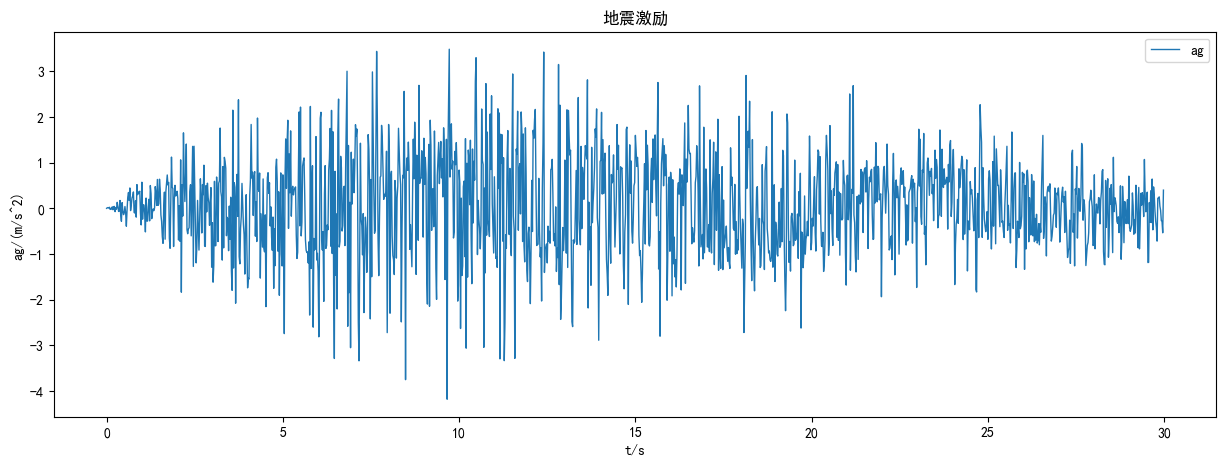

In [20]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,30,0.02),acc[0,:].detach(), label='ag', linewidth=1)
plt.ylabel("ag/(m/s^2)")
plt.xlabel("t/s")
plt.legend(loc='best')
plt.title("地震激励")
plt.show()

In [21]:
acc_lp_0=torch.cat((torch.zeros((acc.shape[0],A.shape[0]-1)),acc),dim=1)[0]
Fnl_lp=torch.zeros_like(acc_lp_0)
F_total_0=torch.stack((acc_lp_0,Fnl_lp),dim=0)

In [22]:
yita=1000
A_nl=A[:,0,:]
V_nl=torch.zeros(1500)

In [23]:
def f(x,P_t,kernels):

    P_t[-1, 1] = yita * k[0] * (x ** 3)
    u_hat = torch.zeros(1)
    
    for j in range(kernels.shape[0]):
        u_hat += kernels[j]@ P_t[:, j].float()

    
    return x-u_hat

In [24]:
def newton_raphson_iteration(f,max_iter, tolerance,P_t,kernels,min_iter):
    
    x = 0.0
    iter_count=0
    while iter_count<max_iter:
        iter_count+=1
        y = f(x,P_t,kernels)  
        x=x-y/(1-3*yita*k[0]*kernels[-1,-1]*(x**2))
        if y.abs() < tolerance and iter_count>min_iter:
            return x
    return x

In [25]:
timestamp1=time.time()

for i in range(F_total_0.shape[1]-A_nl.shape[0]+1):
    P_t=F_total_0[:,i:i+A_nl.shape[0]]
    u=newton_raphson_iteration(f=f,max_iter=1000, tolerance=1e-10,P_t=P_t,kernels=A_nl,min_iter=10)
    F_total_0[-1,i+A_nl.shape[0]-1]=yita*k[0]*(u**3)
    V_nl[i]=u

timestamp2=time.time()
time_difference = timestamp2 - timestamp1
print("时间差（秒）：", time_difference)

时间差（秒）： 452.2008526325226


In [26]:
pd.DataFrame(V_nl.numpy()).to_csv("result_data/ETDM_Newton_resutl.csv")

In [27]:
result1=-pd.read_csv("result_data/Newmark_beta_result.csv").iloc[0, 1:]

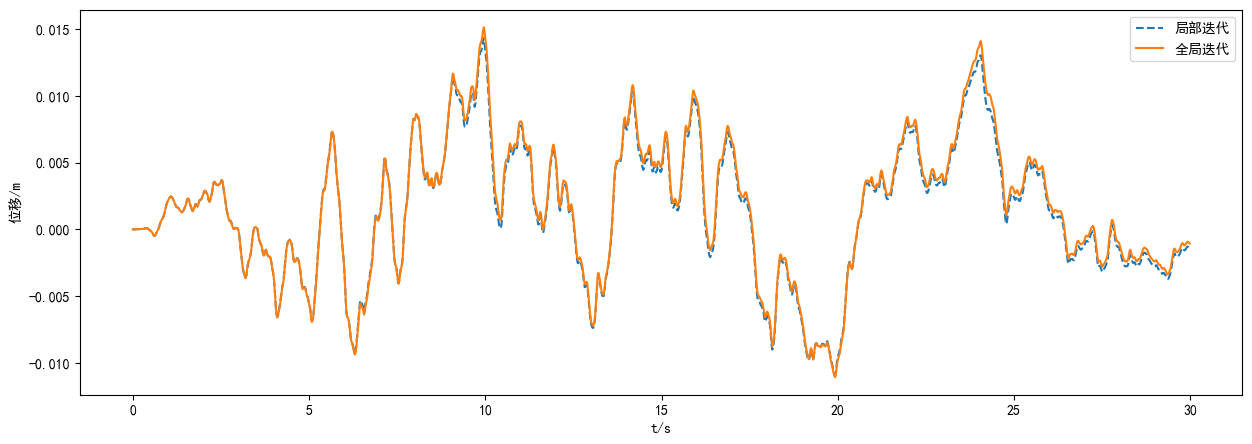

In [28]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,30,0.02),V_nl,label="局部迭代",linestyle="--")
plt.plot(np.arange(0,30,0.02),np.array(result1),label="全局迭代",linestyle="-")
plt.xlabel("t/s")
plt.ylabel("位移/m")
plt.legend(loc="best")
plt.show()

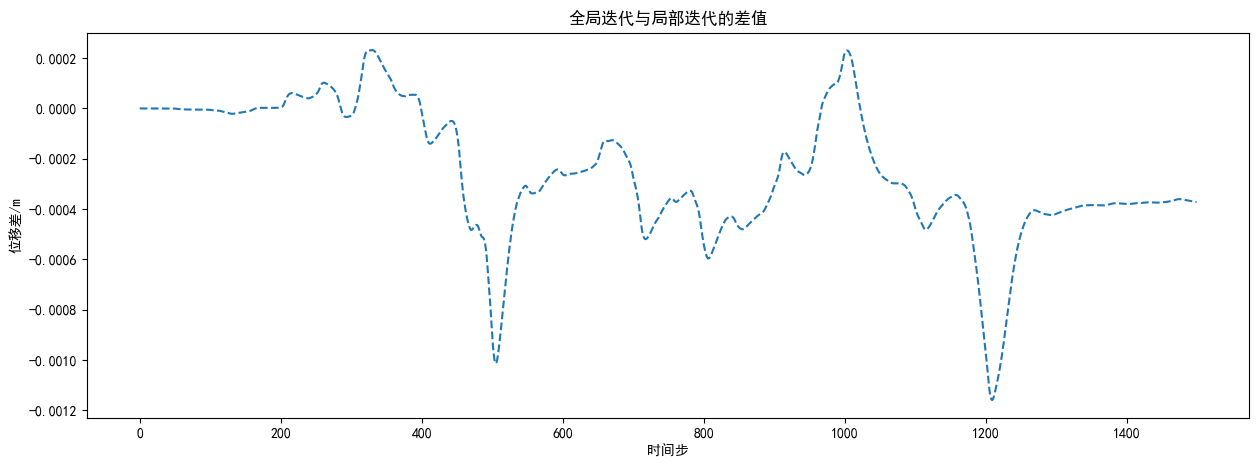

In [29]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),(V_nl-np.array(result1)),linestyle="--")
plt.title("全局迭代与局部迭代的差值")
plt.xlabel("时间步")
plt.ylabel("位移差/m")
plt.show()

In [30]:
from torcheval.metrics.functional import r2_score
r2 = r2_score(V_nl,torch.from_numpy(np.array(result1)))
r2

tensor(0.9950, dtype=torch.float64)